In [1]:
import dataimport 
import pca_decomp as pca
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import statsmodels.api as sm


import warnings
warnings.filterwarnings("ignore")

In [2]:
#Importing the datacode 
data_code = pd.read_excel("C:/Users/tchozin/Desktop/Python projects/Dual Mandate Forecast/data_pce_lead.xlsx")
df_main_pca, df_main_reg, df_raw = dataimport.data_main(data_code ,1990)


#Making sure both input and output series are same length
df_clean_pca =  df_main_pca[12:len(df_main_pca)-1].fillna(method='bfill').fillna(method='ffill')
df_clean_reg =  df_main_reg[12:len(df_main_reg)-1].fillna(method='bfill').fillna(method='ffill')


df_clean_pca = df_clean_pca[df_clean_pca.index <= pd.Timestamp.today()]
df_clean_reg = df_clean_reg[df_clean_reg.index <= pd.Timestamp.today()]

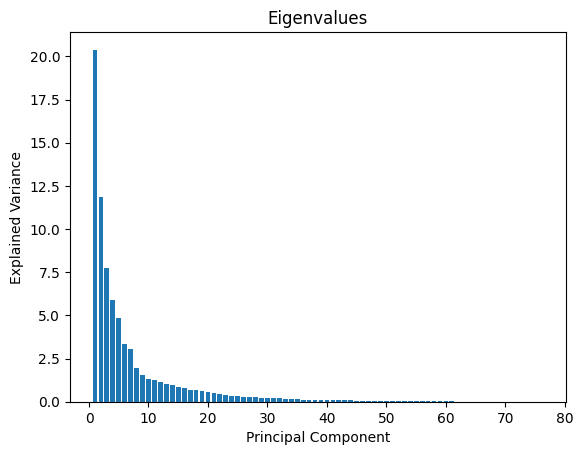

In [3]:
principal_comp, eigenvalues = pca.pca_model(df_clean_pca)
principal_comp_firstfour = principal_comp.iloc[:, :4] 


#Plotting the eigen values
plt.bar(range(1, len(eigenvalues) + 1), eigenvalues)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance')
plt.title('Eigenvalues')
plt.show()


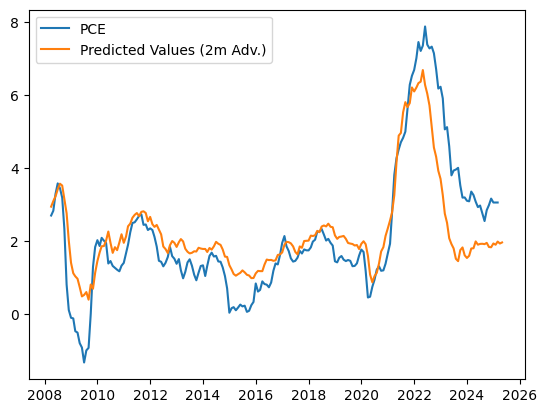

Mean Squared Error:  90.503 
R^2: 0.727


In [ ]:

#combining the data frame for input variables and greating lagged value
lagg_for_depend = 2
lagg_for_pca = 2

#This is to add new rows when shifting the data up ward
new_date_index = pd.date_range(start=principal_comp_firstfour.index[-1] + pd.Timedelta(days=1), periods=lagg_for_pca, freq='MS')
new_rows = pd.DataFrame(np.nan, index=new_date_index, columns=["extrarow"])

#the X values is just the PCA
pcshifted = pd.concat([principal_comp_firstfour, new_rows], axis=1).resample('MS').first()

#This is with a lag of the output variable
#pcshifted = pd.concat([df_clean_reg, principal_comp_firstfour, new_rows], axis=1).resample('MS').first()

del pcshifted['extrarow'] 
df_combined_lagged = pd.concat([pcshifted.shift(lagg_for_pca)], axis=1)

#main data resizing to compensate for the na values
df_clean_reg_resize = df_clean_reg[lagg_for_depend:] #.dropna()
df_combined_lagged_main = df_combined_lagged[lagg_for_depend:] #.dropna()


# Split data into training and testing sets (50% training, 50% testing)
train_size = int(len(df_combined_lagged_main) * 0.5) 
X_train, X_test = df_combined_lagged_main[:train_size], df_combined_lagged_main[train_size:]
Y_train, Y_test = df_clean_reg_resize[:train_size], df_clean_reg_resize[train_size:]


#Ols to predict infaltion
lr = LinearRegression()
lr.fit(X_train, Y_train)
y_pred = lr.predict(X_test)

y_pred = pd.DataFrame(y_pred, index=X_test.index.values, columns=["Predicted"])

plt.plot(Y_test.rolling(window=1).mean(), label="PCE")
plt.plot(y_pred.rolling(window=1).mean(), label="Predicted Values (2m Adv.)")
plt.legend()
plt.show()


print("Mean Squared Error: ", np.round(mean_squared_error(Y_test, y_pred[:len(Y_test)])*100, decimals=3), "\nR^2:" ,

#R2 is negative only when the chosen model does not follow the trend of the data, so fits worse than a horizontal line.
np.round(r2_score(Y_test, y_pred[:len(Y_test)]), decimals=3))

In [5]:
#Summary Statistics on full data set
log_clf =sm.OLS(df_clean_reg_resize ,df_combined_lagged_main.iloc[:, :4][:len(df_clean_reg_resize)])
classifier = log_clf.fit()
print(classifier.summary2())


                             Results: Ordinary least squares
Model:                  OLS                        Adj. R-squared (uncentered): 0.284    
Dependent Variable:     _OUTPUT_12MCHNG_USPRIC0001 AIC:                         1719.7567
Date:                   2025-03-24 09:58           BIC:                         1735.8116
No. Observations:       409                        Log-Likelihood:              -855.88  
Df Model:               4                          F-statistic:                 41.59    
Df Residuals:           405                        Prob (F-statistic):          3.28e-29 
R-squared (uncentered): 0.291                      Scale:                       3.8852   
------------------------------------------------------------------------------------------------
               Coef.         Std.Err.           t           P>|t|          [0.025         0.975]
------------------------------------------------------------------------------------------------
PC1            0.1

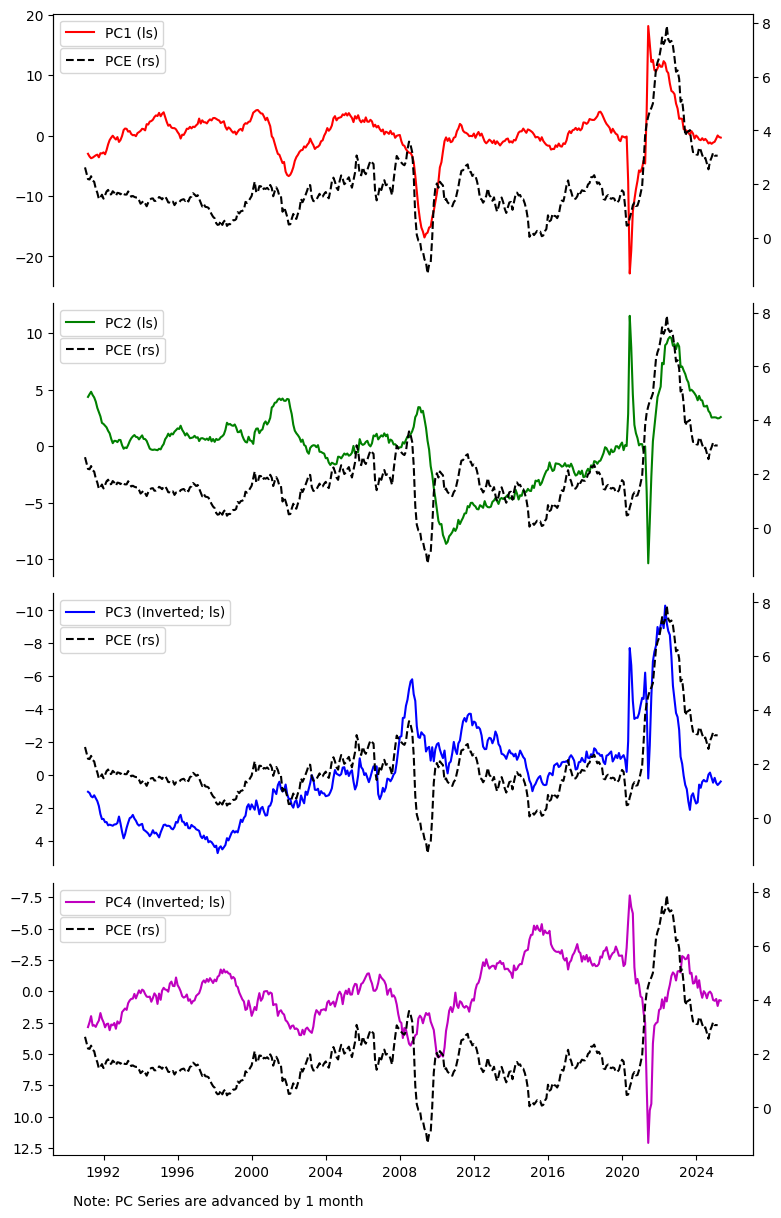

In [6]:

# Create a 4x1 grid of subplots (all aligned vertically)
fig, axs = plt.subplots(4, 1, figsize=(8, 12))

# Plot in the first panel (top)
axs[0].plot(df_combined_lagged_main.iloc[:, :1], 'r', label='PC1 (ls)')
axs[0].spines['bottom'].set_visible(False)
axs[0].set_xticks([])  # Remove x-axis labels for the fourth plot
axs[0].legend(loc='upper left')

# Plot in the second panel
axs[1].plot(df_combined_lagged_main.iloc[:, 1:2], 'g', label='PC2 (ls)')
axs[1].spines['top'].set_visible(False)
axs[1].spines['bottom'].set_visible(False)
axs[1].set_xticks([])  # Remove x-axis labels for the fourth plot
axs[1].legend(loc='upper left')

# Plot in the third panel
axs[2].plot(df_combined_lagged_main.iloc[:, 2:3], 'b', label='PC3 (Inverted; ls)')
#axs[2].set_ylim(-10, 10)  # Limit y-axis for tan(x) to avoid extreme values
axs[2].spines['top'].set_visible(False)
axs[2].spines['bottom'].set_visible(False)
axs[2].set_xticks([])  # Remove x-axis labels for the fourth plot
axs[2].legend(loc='upper left')
axs[2].invert_yaxis()
# Plot in the fourth panel (bottom)
axs[3].plot(df_combined_lagged_main.iloc[:, 3:4], 'm', label='PC4 (Inverted; ls)')
axs[3].spines['top'].set_visible(False)
axs[3].legend(loc='upper left')
axs[3].invert_yaxis()


for i in range(4):
    ax2 = axs[i].twinx()  # Get the secondary axis for each subplot
    ax2.plot(df_clean_reg.shift(0), 'b', label='PCE (rs)', linestyle='--', color='black')  # Plot on the secondary axis
    ax2.spines['top'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.legend(loc='upper left',bbox_to_anchor=(0, 0.9))  # Optional: Add a legend for the second series
# Adjust the layout to prevent overlap

footnote_text = "Note: PC Series are advanced by 1 month"
plt.figtext(0.29, 0.0, footnote_text, ha='center', va='top', fontsize=10)

plt.tight_layout()

# Show the figure with the four vertically aligned panels
plt.show()


In [ ]:
#y_pred[:len(Y_test)].to_excel("testing1234.xlsx")